In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import untils
from DeepTaxonNet import DeepTaxonNet
import argparse
import utils

from sklearn.mixture import GaussianMixture

import os
import sys

In [3]:
# load mnist
download = True
dataset_class = datasets.MNIST
mnist_transform = [transforms.ToTensor()]
# normalize
# mnist_transform.append(transforms.Normalize((0.1307,), (0.3081,)))
# mnist_transform.append(transforms.Normalize((0.1307,), (0.3081,)))

dataset_transform = transforms.Compose(mnist_transform)
mnist_train = dataset_class('data/MNIST', train=True, download=download, transform=dataset_transform)
mnist_test = dataset_class('data/MNIST', train=False, download=download, transform=dataset_transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True, num_workers=1, pin_memory=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=1024, shuffle=True, num_workers=1, pin_memory=True)

In [4]:
train_loader, test_loader, train_set, test_set = utils.get_data_loader('cifar-10', 128, False)

/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [6]:
def t_sne(model, test_loader, device, epoch):
    all_latent = []
    all_labels = []
    all_pcx = []
    pis = []
    mu_c = None
    for i, (data, target) in enumerate(test_loader):
        with torch.no_grad():
            data = data.view(-1, 28*28).to(device)
            mu, logvar = model.encode(data)
            latent = model.reparameterize(mu, logvar)
            all_latent.append(latent)
            all_labels.append(target)

            _, H, pcx, pi = model(data)
            all_pcx.append(pcx)
            # pis.append(pi)
            pis = pi.cpu().numpy()


            if i == 2:
                break
            mu_c = model.gmm_params()[1]
            centroids = model.decode(mu_c)
            centroids = centroids.view(-1, 28, 28).detach().cpu().numpy()
            # plot 8 * 8 centroids 
    # plt.figure(figsize=(8, 8))
    # for i in range(len(centroids)):
    #     plt.subplot(16, 16, i+1)
    #     plt.imshow(centroids[i], cmap='gray')
    #     plt.axis('off')
    # plt.savefig('viz_out/vade_muc.png')
    # plt.close()
    # plt.show()

    # plot entropy at each layer
    num_layers = len(H)
    colors = plt.cm.viridis(np.linspace(0, 1, num_layers))
    fig = plt.figure(figsize=(5, 5))
    for i, entropy in enumerate(H):
        entropy = entropy.cpu().numpy()
        plt.scatter(np.arange(entropy.shape[0]), entropy, alpha=0.5, color=colors[i])
        
    # fig, axs = plt.subplots(1, 8, figsize=(15, 3))
    # H_temp = torch.cat(H, dim=0) # batch_size, n_classes
    # vmax = H_temp.max()
    # vmin = H_temp.min()
    # for i, entropy in enumerate(H):
    #     entropy = entropy.unsqueeze(0).cpu().numpy()
    #     # print(entropy.shape)
    #     # print(entropy)
    #     # axs[i].imshow(entropy, cmap='viridis', vmin=vmin, vmax=vmax)
    #     im = axs[i].imshow(entropy, cmap='viridis', vmin=vmin, vmax=vmax)
    #     # Add the colorbar using the figure's colorbar method
    #     fig.colorbar(im, ax=axs[i])
    #     # add color bar legend
    #     # axs[i].colorbar()
    #     # plot a spectrum of entropy 

    #     axs[i].axis('off')
    #add color bar legend
    # cbar = plt.colorbar(axs[0].imshow(entropy, cmap='viridis', vmin=vmin, vmax=vmax), ax=axs, orientation='horizontal')
    # cbar.set_label('Entropy')
    # axs[0].set_title('Entropy at each layer')
    # axs[0].set_title('Entropy at each layer')
    plt.savefig(f'viz_out/vade_entropy.png')
    plt.close()



    all_latent = torch.cat(all_latent, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    all_latent = all_latent.cpu().numpy()
    # concate with mu_c
    all_latent = np.concatenate((all_latent, mu_c.detach().cpu().numpy()), axis=0)
    all_labels = all_labels.cpu().numpy()

    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(all_latent)
    # plt.figure(figsize=(5, 5))
    # subplots, 1 by 3
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].scatter(tsne_results[:len(all_labels), 0], tsne_results[:len(all_labels), 1], c=all_labels, cmap='tab10', s=10)
    # axs[0].colorbar()
    axs[0].scatter(tsne_results[len(all_labels):, 0], tsne_results[len(all_labels):, 1], c='black', s=50, marker='x')
    # plt.colorbar()


    # subplot 2, pcx 
    pcx = torch.cat(all_pcx, dim=0) # batch_size, n_classes
    pcx = pcx.cpu().numpy()
    # plot line plot for each data point and color by label
    axs[1].plot(pcx[:len(all_labels), :].T, c='blue', alpha=0.003)
    # multiple bars
    # for i in range(pcx.shape[0]):
        # axs[1].bar(np.arange(pcx.shape[1]), pcx[i], color='blue', alpha=0.005)

    # subplot 3, pi, shape (n_classes,)
    axs[2].plot(pis.T, c='red', alpha=0.5)
    # axs[2].bar(np.arange(pis.shape[0]), pis, color='red', alpha=0.5)

    # plt.savefig(f'viz_out/vade{epoch}.png')
    # plt.savefig(f'viz_out/vade_tree_{epoch}.png')
    plt.savefig(f'viz_out/vade_tree_0.png')

    plt.close()






In [7]:
# a = torch.randn(2, 3)
a = torch.randn((2,3), dtype=torch.float32, device=device)
# print(a)
torch.empty_like(a)

tensor([[0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')

In [15]:
n_layers=6
# model = DeepTaxonNet(
#     n_layers=n_layers,
#     enc_hidden_dim=128,
#     dec_hidden_dim=128,
#     input_dim=3*32*32,
#     latent_dim=128,
#     encoder_name='mlp',
#     decoder_name='mlp',
# ).to(device)

model = DeepTaxonNet(
    n_layers=n_layers,
    enc_hidden_dim=64*8*8,
    dec_hidden_dim=(64,8,8),
    input_dim=3*32*32,
    latent_dim=768,
    encoder_name='resnet18_light',
    decoder_name='resnet18_light',
    kl1_weight=1
).to(device)

# model = DeepTaxonNet(
#     n_layers=n_layers,
#     enc_hidden_dim=64*1*1,
#     dec_hidden_dim=(64,1,1),
#     input_dim=3*32*32,
#     latent_dim=64,
#     encoder_name='vgg',
#     decoder_name='vgg',
# ).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# pretrain
optimizer_pretrain = optim.AdamW(
    list(model.encoder.parameters()) + 
    list(model.decoder.parameters()) +
    list(model.fc_mu.parameters()),
    # list(model.fc_logvar.parameters()),
    lr=1e-3,
)
utils.pretrain(model, train_loader, optimizer_pretrain, 1, device) 

# train 
epochs = 10
for epoch in range(epochs):
    model.train()
    for i, (data, _) in enumerate(train_loader):
        data = data.to(device)
        #---------ELBO loss------------#
        optimizer.zero_grad()
        loss, recon_loss, kl1, kl2, _, _, _ = model(data)
        # loss, recloss, kl1, _ = model.vae_forward(data)
        # print('loss:', loss.item(), 'recloss:', recloss.item(), 'kl1:', kl1.item(), 'kl2:', kl2.item())
        # break
        # print('kl1:', kl1.item(), 'recloss:', recloss.item())
        #----------------------------#
        loss.backward()
        optimizer.step()
        # if i % 100 == 0:
    print('Epoch:', epoch, 'Loss:', loss.item())
    # testing
    # utils.linear_probing(model, 10, mnist_train_loader, mnist_test_loader, 1e-3, 1, device)
    # if epoch==9:
        # all_latent, all_labels, pcx, pis, centroid_list, H = utils.get_latent(model, test_loader, device)
    
    # if epoch % 10 == 1:
    #     model.eval()
    #     t_sne(model, mnist_test_loader, device, epoch)

100%|██████████| 1/1 [00:09<00:00,  9.22s/it]


recon_loss 46.43926239013672 kl1 1779.628173828125 kl2 0.1200433224439621
recon_loss 133.39987182617188 kl1 1017.6502685546875 kl2 0.0708824023604393
recon_loss 166.01063537597656 kl1 671.50732421875 kl2 0.054783500730991364
recon_loss 144.72860717773438 kl1 572.77294921875 kl2 0.049254611134529114
recon_loss 127.972900390625 kl1 488.0032958984375 kl2 0.05081447213888168
recon_loss 142.99359130859375 kl1 402.1414794921875 kl2 0.04713553935289383
recon_loss 128.84469604492188 kl1 337.0289306640625 kl2 0.0432683564722538
recon_loss 144.2336883544922 kl1 279.9475402832031 kl2 0.03867753595113754
recon_loss 128.2108154296875 kl1 253.01910400390625 kl2 0.03796187788248062
recon_loss 138.5419464111328 kl1 232.86053466796875 kl2 0.040858276188373566
recon_loss 118.25263977050781 kl1 215.97166442871094 kl2 0.04327026754617691
recon_loss 125.12782287597656 kl1 200.9405975341797 kl2 0.04372827708721161
recon_loss 116.96852111816406 kl1 174.98641967773438 kl2 0.03965669870376587
recon_loss 117.72

KeyboardInterrupt: 

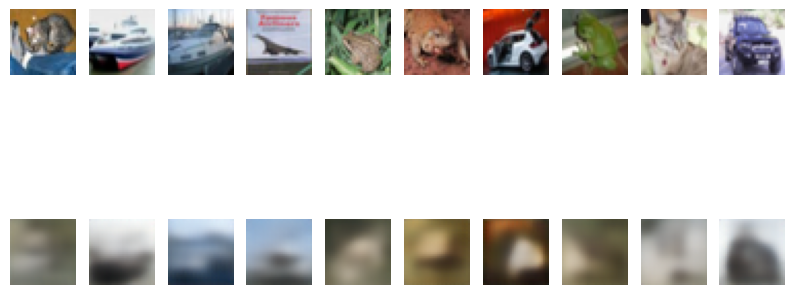

In [16]:
# test image reconstruction
model.eval()
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data = data.to(device)
        latent, logvar = model.encode(data)
        latent = model.reparameterize(latent, logvar)
        x_hat = model.decode(latent)
        # latent = model.encoder(data)
        # x_hat = model.decoder_raw(latent)
        break

# plot original and reconstructed images
# original images
data = data.view(-1, 3, 32, 32).cpu().numpy()[:10]
# reconstructed images
x_hat = x_hat.view(-1, 3, 32, 32).cpu().numpy()[:10]
# plot 10 images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(data[i].transpose(1, 2, 0))
    plt.axis('off')
    plt.subplot(2, 10, i+11)
    plt.imshow(x_hat[i].transpose(1, 2, 0))
    plt.axis('off')

plt.show()

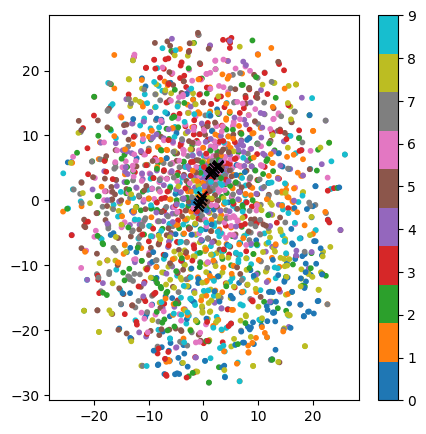

In [25]:
utils.plot_tsne(all_latent, all_labels).show()

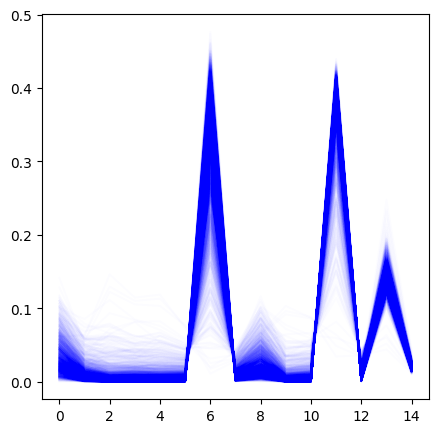

In [26]:
utils.plot_qcx(pcx).show()

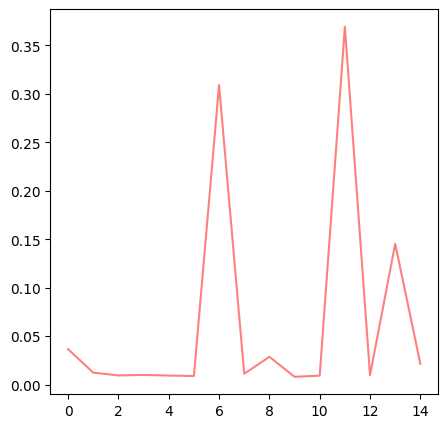

In [27]:
utils.plot_pi(pis).show()

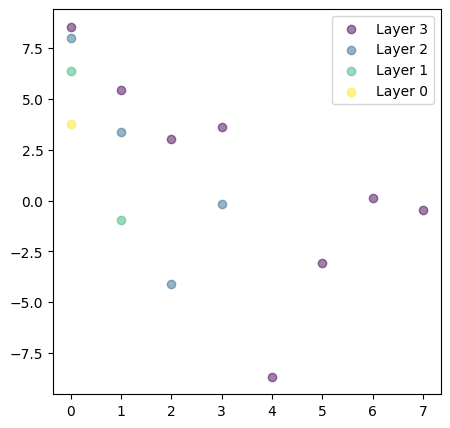

In [121]:
utils.plot_entropy(H).show()

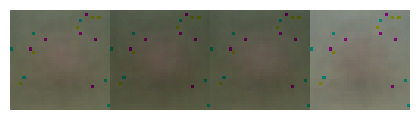

In [28]:
utils.plot_centroids(centroid_list, 2).show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0895224].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0104934].


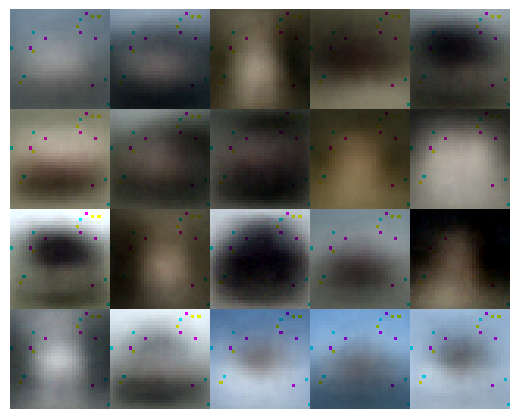

In [29]:
utils.plot_generated_examples(model, 2, 5, device).show()

/nethome/zwang910/research/unsupervised-prototypes/utils.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pcx = torch.tensor(pcx, device=device)
/nethome/zwang910/research/unsupervised-prototypes/utils.py:259: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_latents = torch.tensor(all_latents, device=device)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0870266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1022193].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

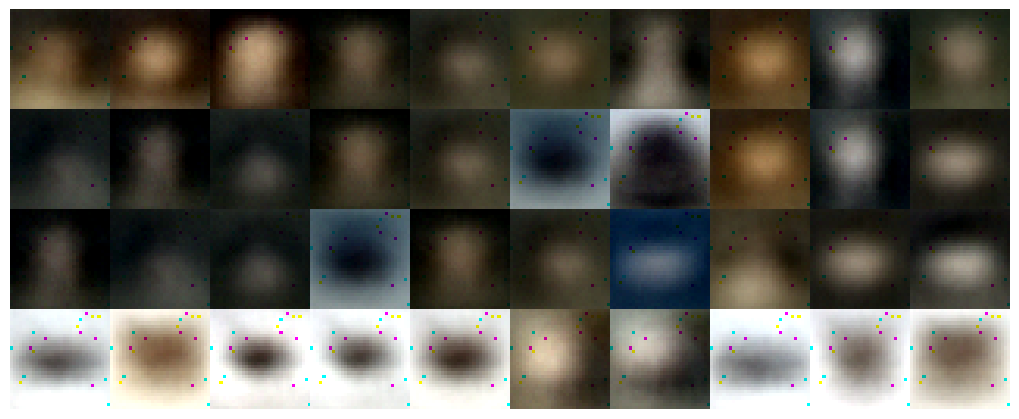

In [30]:
utils.plot_dataset_examples(model, all_latent, pcx, 2, 10, device).show()

In [32]:
# save model
torch.save(model.state_dict(), 'vade_tree.pth')

In [33]:
# load model
n_layers=4
model = GMMDeepTaxonNet(n_layers=n_layers, 
                        encoder_shared=True
                        ).to(device)
model.load_state_dict(torch.load('vade_tree.pth'))

<All keys matched successfully>

In [10]:
# linear probing
model.eval()
# freeze model
for param in model.parameters():
    param.requires_grad = False
# add linear layer
classifier = nn.Linear(model.latent_dim, 10).to(device)
classifier_optimizer = optim.Adam(classifier.parameters(), lr=2e-3)
classifier_loss = nn.CrossEntropyLoss()
# train linear layer
epochs = 100

for epoch in range(epochs):
    for i, (data, target) in enumerate(mnist_train_loader):
        data = data.view(-1, 28*28).to(device)
        target = target.to(device)
        #---------ELBO loss------------#
        optimizer.zero_grad()
        with torch.no_grad():
            mu, logvar = model.encode(data)
            latent = model.reparameterize(mu, logvar)
        # print('latent:', latent.shape)
        output = classifier(latent)
        loss = classifier_loss(output, target)
        # print('loss:', loss.item(), 'recloss:', recloss.item(), 'kl1:', kl1.item(), 'kl2:', kl2.item())
        # break
        # print('kl1:', kl1.item(), 'kl2:', kl2.item())
        #----------------------------#
        loss.backward()
        classifier_optimizer.step()
    print('Epoch:', epoch, 'Loss:', loss.item())
    # test linear layer
    model.eval()
    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(mnist_test_loader):
            data = data.view(-1, 28*28).to(device)
            target = target.to(device)
            mu, logvar = model.encode(data)
            latent = model.reparameterize(mu, logvar)
            output = classifier(latent)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    print('Accuracy:', correct / total)




Epoch: 0 Loss: 0.9391748309135437
Accuracy: 0.8009
Epoch: 1 Loss: 1.0666286945343018
Accuracy: 0.8637
Epoch: 2 Loss: 0.5552490949630737
Accuracy: 0.8742
Epoch: 3 Loss: 1.0778722763061523
Accuracy: 0.8713
Epoch: 4 Loss: 0.9034507870674133
Accuracy: 0.8718
Epoch: 5 Loss: 0.6092457175254822
Accuracy: 0.8751
Epoch: 6 Loss: 0.789405345916748
Accuracy: 0.8678
Epoch: 7 Loss: 1.0889869928359985
Accuracy: 0.8697
Epoch: 8 Loss: 0.9380680918693542
Accuracy: 0.8623
Epoch: 9 Loss: 0.3511514663696289
Accuracy: 0.8805
Epoch: 10 Loss: 0.46604177355766296
Accuracy: 0.8724
Epoch: 11 Loss: 0.38379549980163574
Accuracy: 0.8611
Epoch: 12 Loss: 1.096359372138977
Accuracy: 0.8663
Epoch: 13 Loss: 1.4137498140335083
Accuracy: 0.8483
Epoch: 14 Loss: 0.14264723658561707
Accuracy: 0.8557
Epoch: 15 Loss: 2.048431634902954
Accuracy: 0.8666
Epoch: 16 Loss: 2.9612972736358643
Accuracy: 0.8568
Epoch: 17 Loss: 0.6289511322975159
Accuracy: 0.8688
Epoch: 18 Loss: 1.1387780904769897
Accuracy: 0.8443
Epoch: 19 Loss: 0.5491

KeyboardInterrupt: 

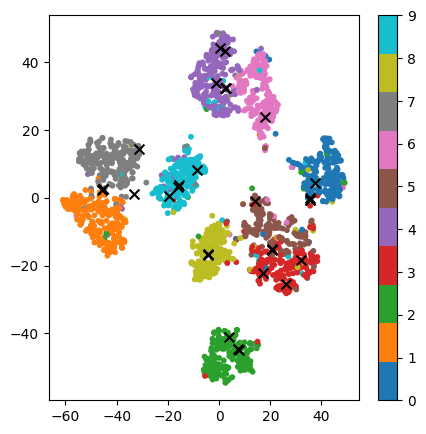

In [9]:
# plot datapoints along with the centroids
all_latent = []
all_labels = []
mu_c = None

with torch.no_grad():
    for i, (data, target) in enumerate(mnist_test_loader):
        data = data.view(-1, 28*28).to(device)
        mu, logvar = model.encode(data)
        latent = model.reparameterize(mu, logvar)
        all_latent.append(latent)
        all_labels.append(target)
        if i == 1:
            break
    mu_c = model.gmm_params()[1].detach().cpu().numpy()
    # mu_c = mu_c[-5:]
    # print(mu_c.shape)


all_latent = torch.cat(all_latent, dim=0)
all_labels = torch.cat(all_labels, dim=0)
all_latent = all_latent.cpu().numpy()
# concate with mu_c
all_latent = np.concatenate((all_latent, mu_c), axis=0)


all_labels = all_labels.cpu().numpy()

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(all_latent)
plt.figure(figsize=(5, 5))
plt.scatter(tsne_results[:len(all_labels), 0], tsne_results[:len(all_labels), 1], c=all_labels, cmap='tab10', s=10)
plt.colorbar()
plt.scatter(tsne_results[len(all_labels):, 0], tsne_results[len(all_labels):, 1], c='black', s=50, marker='x')


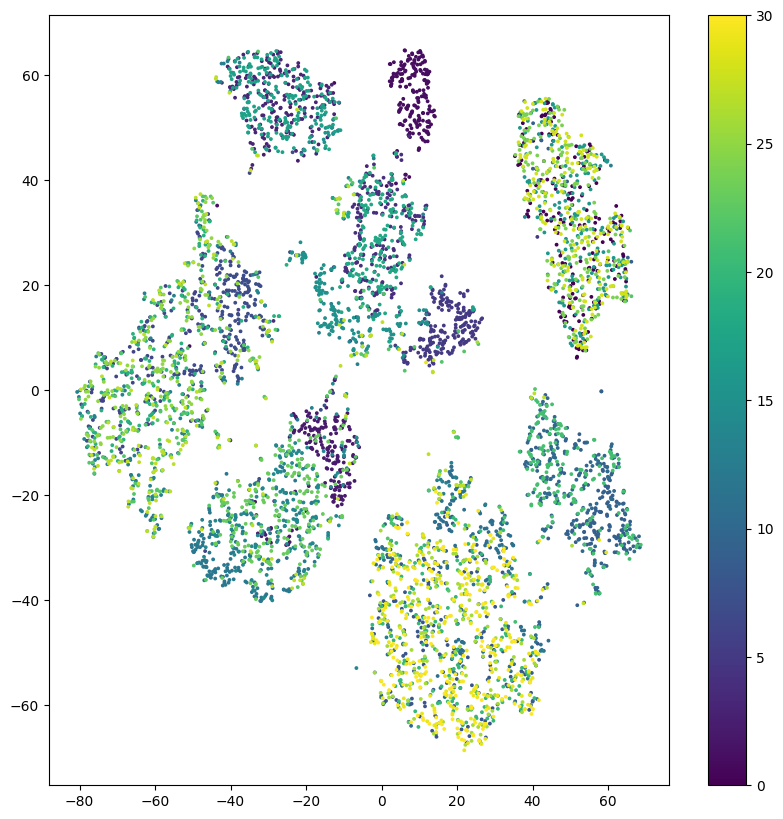

In [62]:
# plot gmms by samplign 100 datapoints at each cluster
# sample 100 points from each cluster
n_samples = 200
with torch.no_grad():
    mu_c = model.gmm_params()[1]
    lagvar_c = model.gmm_params()[2] # n_classes, latent_dim
    # for each cluster, sample 100 points

    labels = torch.arange(len(mu_c)).unsqueeze(1).expand(-1, n_samples).reshape(-1) # n_classes * n_samples
    # print(labels) 

    mu_c = mu_c.unsqueeze(1).repeat(1, n_samples, 1).reshape(-1, model.latent_dim)
    lagvar_c = lagvar_c.unsqueeze(1).repeat(1, n_samples, 1).reshape(-1, model.latent_dim) # n_classes * n_samples, latent_dim
    # print(lagvar_c)
    z = model.reparameterize(mu_c, lagvar_c)

    # tsne
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(z.cpu().numpy())
    plt.figure(figsize=(10, 10))
    plt.scatter(tsne_results[:len(labels), 0], tsne_results[:len(labels), 1], c=labels, cmap='viridis', s=3, marker='o')
    plt.colorbar()
    # plt.savefig('viz_out/vade_gmm.png')
    plt.show()



    # x_hat = model.decode(z)




In [18]:
with torch.no_grad():
    for i, (data, target) in enumerate(mnist_test_loader):
        data = data.view(-1, 28*28).to(device)
        # forward pass
        model(data)
        if i == 0:
            break

torch.Size([30, 32]) torch.Size([30, 32]) torch.Size([30])


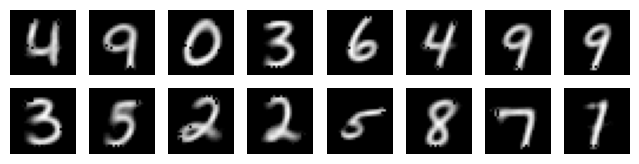

In [14]:
# decode the centroids
at_layer = 5 # root layer
if at_layer == 1:
    centroids = model.gmm_params()[1][-(2**(at_layer)-1):]
else:
    centroids = model.gmm_params()[1][-(2**(at_layer)-1):-(2**(at_layer-1)-1)]

# centroids = torch.zeros(1, 32).to(device)
centroids = model.decode(centroids)
centroids = centroids.view(-1, 28, 28).detach().cpu().numpy()
# plot 8 * 8 centroids 
plt.figure(figsize=(8, 8))
for i in range(len(centroids)):
    plt.subplot(8, 8, i+1)
    plt.imshow(centroids[i], cmap='gray')
    plt.axis('off')
# plt.savefig('viz_out/centroids.png')
plt.show()

In [15]:
# print gaussian p(c) at each layer
pi = model.gmm_params()[0].detach().cpu().numpy()
# print('pi:', pi)
# print pi
n_layers = model.n_layers
for i in range(0, n_layers):
    if i == 0:
        print('Layer:', i, 'p(c):', pi[-(2**(i+1)-1):])
    else:
        print('Layer:', i, 'p(c):', pi[-(2**(i+1)-1):-(2**i-1)])

Layer: 0 p(c): [0.04656837]
Layer: 1 p(c): [0.06666263 0.0200983 ]
Layer: 2 p(c): [6.6571608e-02 5.6309395e-02 1.0357273e-02 4.0336909e-06]
Layer: 3 p(c): [6.3518047e-02 3.2458169e-07 6.6666342e-02 6.2970512e-02 3.6961555e-03
 4.3083075e-02 2.3583591e-02 9.5061499e-05]


In [8]:
import torch
import matplotlib.pyplot as plt

def sample_from_learned_gaussian(model, device, grid_size=8):
    """
    Samples images from the learned Gaussian prior of a VaDE model (with a single Gaussian)
    and displays them in an 8x8 grid.
    
    Parameters:
        model: The trained VaDE model with a .gmm_params() method and a decoder.
        device: The device (e.g., torch.device("cuda") or torch.device("cpu")).
        grid_size: Number of rows/columns in the grid (default is 8 for an 8x8 grid).
    """
    model.eval()  # Set the model to evaluation mode
    num_samples = grid_size * grid_size  # Total number of samples (e.g., 64 for an 8x8 grid)
    
    with torch.no_grad():
        # Retrieve the learned GMM parameters (for a single Gaussian)
        pi, learned_mu, learned_logvar = model.gmm_params()
        
        # Ensure the parameters have a batch dimension.
        # If they are 1D tensors (shape [latent_dim]), unsqueeze to shape [1, latent_dim]
        if learned_mu.dim() == 1:
            learned_mu = learned_mu.unsqueeze(0)
            learned_logvar = learned_logvar.unsqueeze(0)
        
        latent_dim = learned_mu.size(1)
        # Expand the learned parameters to sample the desired number of points
        mu_expanded = learned_mu.expand(num_samples, latent_dim)
        logvar_expanded = learned_logvar.expand(num_samples, latent_dim)
        
        # Reparameterization trick using the learned mean and variance
        std = torch.exp(0.5 * logvar_expanded)
        eps = torch.randn(num_samples, latent_dim).to(device)
        z = mu_expanded + eps * std
        
        # Generate images by passing the latent samples through the decoder
        samples = model.decoder(z)
        # Reshape to image format (e.g., for MNIST: 1x28x28)
        samples = samples.view(-1, 1, 28, 28)
    
    # Plot the generated samples using an 8x8 grid of subplots
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size, grid_size))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].cpu().numpy().squeeze(), cmap='gray')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'model' is your trained VaDE model and 'device' is properly set.
sample_from_learned_gaussian(model, device)


RuntimeError: The expanded size of the tensor (64) must match the existing size (31) at non-singleton dimension 0.  Target sizes: [64, 32].  Tensor sizes: [31, 32]